In [2]:
import random
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

Чтение файлов

In [9]:
class ReadPgmImage(Dataset):
    def __init__(self, path_dir='./archive'):  # ← __init__
        self.folders = []  
        self.images = {}
        
        for folder in sorted(os.listdir(path_dir)):
            path = os.path.join(path_dir, folder)
            if os.path.isdir(path):
                self.folders.append(folder)
                self.images[folder] = [
                    os.path.join(path, f) 
                    for f in os.listdir(path) 
                    if f.endswith('.pgm')
                ]
        
        # ← Трансформации: Ч/Б + Тензор + Нормализация
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def __len__(self):  # ← __len__
        return 1000
    
    def __getitem__(self, idx):  # ← __getitem__
        person1 = random.choice(self.folders)
        image1_path = random.choice(self.images[person1])
        
        # 50/50: одинаковые или разные люди
        if random.random() > 0.5:
            # Одинаковые
            other_imgs = [p for p in self.images[person1] if p != image1_path]
            # ← Защита от ошибки, если фото всего одно
            image2_path = random.choice(other_imgs) if other_imgs else image1_path
            label = 1.0
        else:
            # Разные
            other_persons = [p for p in self.folders if p != person1]
            person2 = random.choice(other_persons)
            image2_path = random.choice(self.images[person2])
            label = 0.0
        
        img1 = Image.open(image1_path)
        img2 = Image.open(image2_path)
        
        # ← Применяем трансформации (превращаем в тензор!)
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [10]:
class SiamNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Squeez = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # ← padding
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # ← padding
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
        )
        
        # 92x112 -> после 2 пулингов -> 23x28
        self.Choose = nn.Sequential(
            nn.Linear(128 * 23 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
    
    def forward_one_image(self, x):
        x = self.Squeez(x)
        x = self.Choose(x)
        return F.normalize(x, p=2, dim=1)  # ← Нормализация вектора
    
    def forward(self, x1, x2):  # ← Метод для вызова model(img1, img2)
        return self.forward_one_image(x1), self.forward_one_image(x2)

In [11]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    
    def forward(self, out1, out2, label):
        distance = F.pairwise_distance(out1, out2)
        loss = label * distance**2 + (1 - label) * torch.clamp(self.margin - distance, min=0)**2
        return loss.mean()

In [14]:
def train_step(model, optimizer, criterion, train_dataloader):
    model.train()
    running_loss = 0.
    
    for image1, image2, labels in train_dataloader:        
        optimizer.zero_grad()
        out1, out2 = model(image1, image2)
        loss = criterion(out1, out2, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader)

def train_system(epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on: {device}")
    
    model = SiamNet().to(device)
    criterion = ContrastiveLoss(margin=1.0)  # ← Правильная функция потерь
    
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=0.01, 
        momentum=0.9,
    )
    
    train_losses = []
    dataset = ReadPgmImage()
    loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)
    
    for i in range(epochs):
        loss = train_step(model, optimizer, criterion, loader)
        train_losses.append(loss)
        print(f"Epoch: {i+1}, Loss: {loss:.4f}")
    
    return train_losses, model

In [15]:
losses, model = train_system(epochs=5)

Training on: cpu
Epoch: 1, Loss: 0.2056
Epoch: 2, Loss: 0.0994
Epoch: 3, Loss: 0.0760
Epoch: 4, Loss: 0.0700
Epoch: 5, Loss: 0.0519


In [49]:
def valid_step_on_10(model, criterion, dataset):
    """
    Проверка модели на 10 случайных парах с визуализацией.
    3 колонки: Фото 1 | Фото 2 | Результат
    """
    model.eval()
    
    test_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    # ← 3 колонки: img1 | img2 | результат
    plt.figure(figsize=(15, 10))
    
    total_loss = 0.0
    correct = 0
    num_tests = 10
    
    with torch.no_grad():
        for i, (img1, img2, label) in enumerate(test_loader):
            if i >= num_tests:
                break

            out1, out2 = model(img1, img2)
            
            distance = F.pairwise_distance(out1, out2).item()
            loss = criterion(out1, out2, label).item()
            total_loss += loss
            
            predicted_same = 1.0 if distance < 0.5 else 0.0
            actual_same = label.item()
            
            is_correct = predicted_same == actual_same
            if is_correct:
                correct += 1

            img1_np = img1.squeeze().cpu().numpy()
            img2_np = img2.squeeze().cpu().numpy()

            # Фото 1
            plt.subplot(num_tests, 3, i*3 + 1)
            plt.imshow(img1_np, cmap='gray')
            plt.axis('off')
            
            # Фото 2
            plt.subplot(num_tests, 3, i*3 + 2)
            plt.imshow(img2_np, cmap='gray')
            plt.axis('off')
            
            # Результат
            plt.subplot(num_tests, 3, i*3 + 3)
            label_str = "Один" if actual_same == 1.0 else "Разные"
            pred_str = "Один" if predicted_same == 1.0 else "Разные"
            
            plt.text(0.5, 0.5, f"Дист: {distance:.3f}\nПрогноз: {pred_str}\nРеальность: {label_str}",
                    bbox=dict(facecolor='green' if is_correct else 'red', alpha=0.5))
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


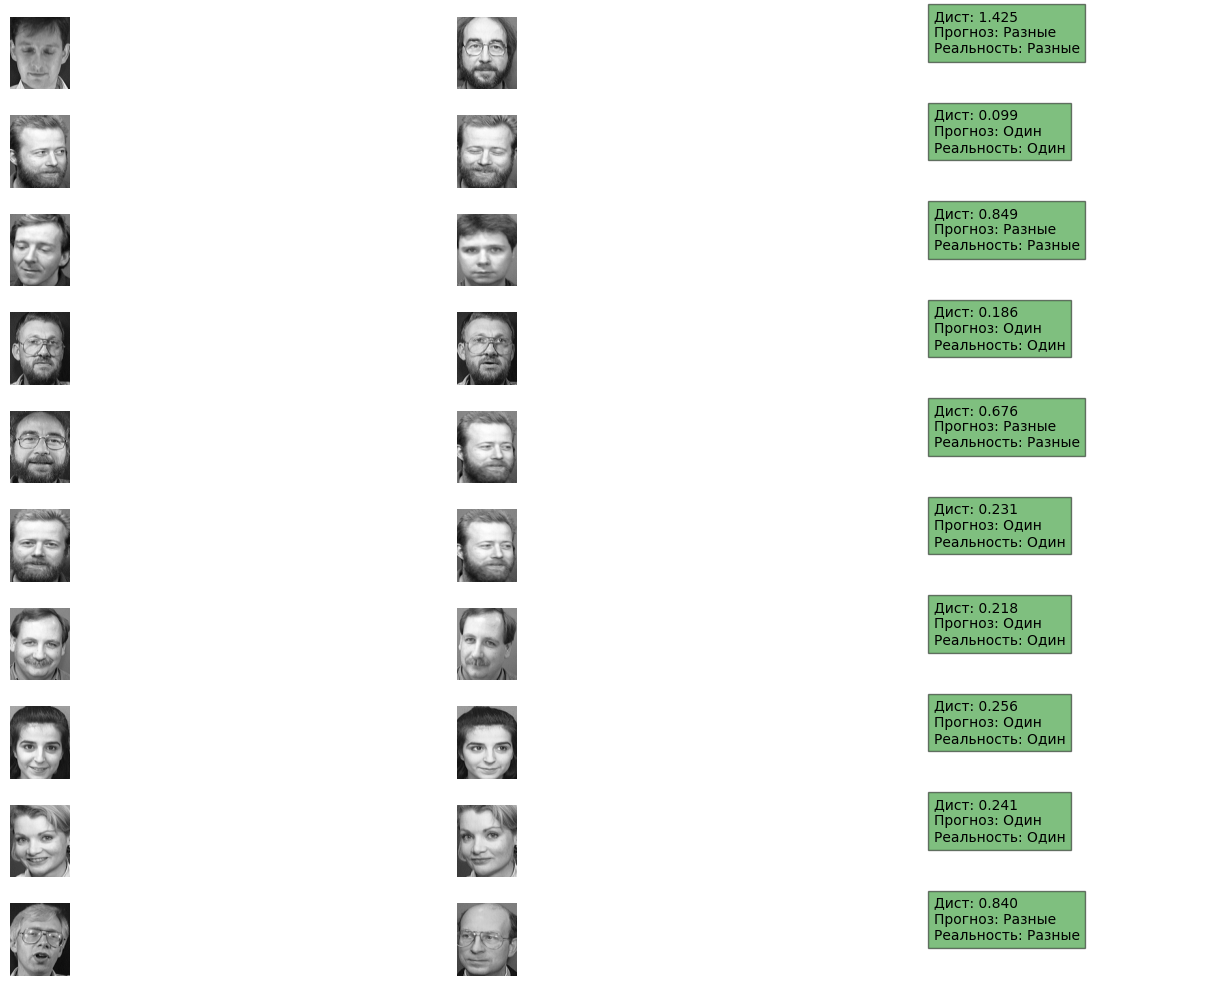

In [50]:
criterion = ContrastiveLoss(margin=1.0)  # ← Правильная функция потерь
dataset = ReadPgmImage()

valid_step_on_10(model, criterion, dataset)